In [138]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, DateType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, expr, count, when, sum as spark_sum

from pathlib import Path
import os

import numpy as np
import matplotlib.pyplot as plt

# Rutas

In [83]:
BASE_DIR = Path(os.getcwd()).parent
RAW_DATA_FILE = BASE_DIR / 'data' / 'raw' / '221003COVID19MEXICO.csv' 

# Esquema

In [58]:
mi_esquema = StructType([
    StructField('FECHA_ACTUALIZACION', DateType(), True),
    StructField('ID_REGISTRO', StringType(), True),
    StructField('ORIGEN', StringType(), True),
    StructField('SECTOR', StringType(), True),
    StructField('ENTIDAD_UM', IntegerType(), True),
    StructField('SEXO', IntegerType(), True),
    StructField('ENTIDAD_NAC', IntegerType(), True),
    StructField('ENTIDAD_RES', IntegerType(), True),
    StructField('MUNICIPIO_RES', IntegerType(), True),
    StructField('FECHA_INGRESO', DateType(), True),
    StructField('FECHA_SINTOMAS', DateType(), True),
    StructField('FECHA_DEF', DateType(), True),
    StructField('INTUBADO', IntegerType(), True),
    StructField('NEUMONIA', IntegerType(), True),
    StructField('EDAD', IntegerType(), True),
    StructField('NACIONALIDAD', IntegerType(), True),
    StructField('EMBARAZO', IntegerType(), True),
    StructField('HABLA_LENGUA_INDIG', IntegerType(), True),
    StructField('INDIGENA', IntegerType(), True),
    StructField('DIABETES', IntegerType(), True),
    StructField('ASMA', IntegerType(), True),
    StructField('INMUSUPR', IntegerType(), True),
    StructField('HIPERTENSION', IntegerType(), True),
    StructField('OTRA_COM', IntegerType(), True),
    StructField('CARDIOVASCULAR', IntegerType(), True),
    StructField('OBESIDAD', IntegerType(), True),
    StructField('RENAL_CRONICA', IntegerType(), True),
    StructField('OTRO_CASO', IntegerType(), True),
    StructField('TOMA_MUESTRA_LAB', IntegerType(), True),
    StructField('RESULTADO_LAB', IntegerType(), True),
    StructField('TOMA_MUESTRA_ANTIGENO', IntegerType(), True),
    StructField('RESULTADO_ANTIGENO', IntegerType(), True),
    StructField('CLASIFICACION_FINAL', IntegerType(), True),
    StructField('MIGRANTE', IntegerType(), True),
    StructField('PAIS_NACIONALIDAD', StringType(), True),
    StructField('PAIS_ORIGEN', StringType(), True),
    StructField('UCI', IntegerType(), True)])

# Crear SparkSession

In [ ]:
'''spark = SparkSession.builder.appName('comorbilidades').getOrCreate()
df = spark.read.option("header", "true") \
               .option("inferSchema", "false") \
               .option("mode", "PERMISSIVE") \
               .option("columnNameOfCorruptRecord", "_corrupt_record") \
               .option("delimiter", ",") \
               .option("quote", "\"") \
               .option("escape", "\'") \
               .option("multiLine", "true") \
               .option("encoding", "UTF-8") \
               .csv(str(RAW_DATA_FILE))
print(f"Total registros: {df.count():,}")
df = df.drop('ID_REGISTRO')
df.show()'''

In [118]:
spark = SparkSession.builder.appName('comorbilidades').getOrCreate()
df = spark.read.csv(
    str(RAW_DATA_FILE), 
    header = True,
    inferSchema=True,
    mode = 'DROPMALFORMED',
    multiLine = False,
    escape = "\"", 
)
print(f"Total registros: {df.count():,}")
df = df.drop('ID_REGISTRO')
df.show()

Total registros: 5,743,499
+-------------------+------+------+----------+----+-----------+-----------+-------------+-------------+-------------+--------------+----------+--------+--------+----+------------+--------+------------------+--------+--------+----+----+--------+------------+--------+--------------+--------+-------------+----------+---------+----------------+-------------+---------------------+------------------+-------------------+--------+-----------------+-----------+---+
|FECHA_ACTUALIZACION|ORIGEN|SECTOR|ENTIDAD_UM|SEXO|ENTIDAD_NAC|ENTIDAD_RES|MUNICIPIO_RES|TIPO_PACIENTE|FECHA_INGRESO|FECHA_SINTOMAS| FECHA_DEF|INTUBADO|NEUMONIA|EDAD|NACIONALIDAD|EMBARAZO|HABLA_LENGUA_INDIG|INDIGENA|DIABETES|EPOC|ASMA|INMUSUPR|HIPERTENSION|OTRA_COM|CARDIOVASCULAR|OBESIDAD|RENAL_CRONICA|TABAQUISMO|OTRO_CASO|TOMA_MUESTRA_LAB|RESULTADO_LAB|TOMA_MUESTRA_ANTIGENO|RESULTADO_ANTIGENO|CLASIFICACION_FINAL|MIGRANTE|PAIS_NACIONALIDAD|PAIS_ORIGEN|UCI|
+-------------------+------+------+----------+----+

### Correcciónes ortográficas y fechas

In [119]:
df = df.filter((col('EDAD') >= 0 ) & (col('EDAD') <= 100))

df = df.withColumn('PAIS_NACIONALIDAD',
              when(col('PAIS_NACIONALIDAD') ==  'MÃ©xico', 'México'))

df = df.withColumn('FECHA_DEF',
              when(col('FECHA_DEF') != '9999-99-99', col('FECHA_DEF')).otherwise(None))

### Casteo de fechas

In [120]:
fechas = [col for col in df.columns if 'FECHA_' in col]
for fecha in fechas:
    df = df.withColumn(fecha,
                       F.to_date(F.column(fecha), 'yyyy-MM-dd'))

### Castear datos que son numericos

In [121]:
numericos = [col for col in df.columns if col != 'PAIS_NACIONALIDAD' and 'FECHA_' not in col]
for c in numericos:
    df.withColumn(c, col(c).cast(IntegerType()))

### Nuevas columnas para un análisis estadístico

In [122]:
def crear_variables_comorblidad(df):
    condiciones = ['DIABETES', 'HIPERTENSION', 'OBESIDAD', 'ASMA', 'EPOC', 'INMUSUPR', 'RENAL_CRONICA', 'TABAQUISMO']
    # Ponerles un contador
    df = df.withColumn('N_COMORBILIDADES',
                       when(col('DIABETES') == 1, 1).otherwise(0) + 
                       when(col('HIPERTENSION') == 1, 1).otherwise(0)+
                       when(col('OBESIDAD') == 1, 1).otherwise(0)+
                       when(col('ASMA') == 1, 1).otherwise(0)+
                       when(col('EPOC') == 1, 1).otherwise(0)+
                       when(col('INMUSUPR') == 1, 1).otherwise(0)+
                       when(col('RENAL_CRONICA') == 1, 1).otherwise(0)+
                       when(col('TABAQUISMO') == 1, 1).otherwise(0)                    
                       )
    df = df.withColumn('COMOR_CARSIOVASCULAR',
                       when((col('HIPERTENSION') == 1) | (col('DIABETES') == 1) | (col('OBESIDAD') == 1), 1).otherwise(0)
                       )
    
    df = df.withColumn('COMOR_RESPIRATORIA',
                       when((col('ASMA') == 1) | (col('EPOC') == 1), 1).otherwise(0)
                       )
    
    df = df.withColumn('COMR_INMUSUPR',
                       when(col('INMUSUPR') == 1, 1).otherwise(0)
                       )
    
    df = df.withColumn('COMR_RENAL',
                       when(col('RENAL_CRONICA') == 1, 1).otherwise(0)
                       )
    
    df = df.withColumn('RIESGO', 
                       when(col('N_COMORBILIDADES') >= 3, 'EXTREMO')
                       .when(col('N_COMORBILIDADES') == 2, 'ALTO')
                       .when(col('N_COMORBILIDADES') == 1, 'MODERADO')
                       .when(col('N_COMORBILIDADES') == 0, 'NORMAL')
                       )
    return df
df = crear_variables_comorblidad(df)

In [123]:
# Variable binaria para saber si son fallecidos
df = df.withColumn('SOBREVIVIO',
                   when(col('FECHA_DEF').isNull(), 1).otherwise(0)
                   )

In [124]:
# Categorizar por grupos de edad
df = df.withColumn('CATEGORIA_EDAD',
                   when(col('EDAD') <= 2, 'BEBES')
                   .when(col('EDAD').between(3, 12), 'NINOS')
                   .when(col('EDAD').between(13, 19), 'JOVENES')
                   .when(col('EDAD').between(20, 50), 'ADULTOS')
                   .when(col('EDAD').between(51, 59), 'ADULTOS_MAYORES')
                   .otherwise('ANCIANOS')
                   )

# Limpieza

### Bebes fumadores

In [130]:
bb_fuma    = df.filter((col('CATEGORIA_EDAD') == 'BEBES') & (col('TABAQUISMO') == 1)).count()
bb_no_fuma = df.filter((col('CATEGORIA_EDAD') == 'BEBES') & (col('TABAQUISMO') != 1)).count()

print(f'bebes fumadores pasivos   : {bb_fuma:,}')
print(f'bebes no fumadores pasivos: {bb_no_fuma:,}')

bebes fumadores pasivos   : 113
bebes no fumadores pasivos: 77,615


### Embarazos mal registrados

In [132]:
cond_bb_emb = (col('CATEGORIA_EDAD')=='BEBES') & (col('EMBARAZO') == 1)
n_bb_emb = df.filter(cond_bb_emb).count()
df = df.filter(~cond_bb_emb)

cond_may_emb = (col('CATEGORIA_EDAD')=='ADULTOS_MAYORES') & (col('EMBARAZO') == 1)
n_may_emb = df.filter(cond_may_emb).count()
df = df.filter(~cond_may_emb)

print(f'Bebés embarazados: {n_bb_emb:,}')
print(f'Adultos mayores embarazados: {n_may_emb:,}')

Bebés embarazados: 35
Adultos mayores embarazados: 154


### Dataframe final

In [134]:
total = df.count()
print(f'Registros limpios: {total:,}')

Registros limpios: 5,742,085


# Preguntas respondidas

### Cuántos sobrevivieron después de ser internados?

In [137]:
si_sobrevivio = df.filter(col('SOBREVIVIO') == 1).count()
no_sobrevivio = df.filter(col('SOBREVIVIO') == 0).count()

porcentaje_sobreviven = np.round((si_sobrevivio/total) * 100, 2)
print(f'Si sobrevivieron: {si_sobrevivio:,}')
print(f'No sobrevivieron: {no_sobrevivio:,}')
print(f'Total {total:,}')
print(f'Sobrevivió el {porcentaje_sobreviven}% de las pesonas internadas')

Si sobrevivieron: 5,705,643
No sobrevivieron: 36,442
Total 5,742,085
Sobrevivió el 99.37% de las pesonas internadas


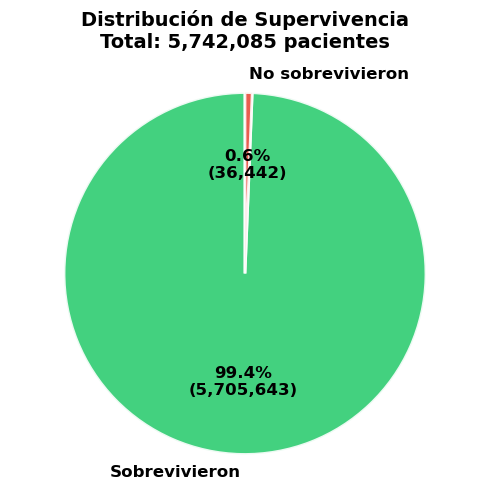

In [ ]:
# Datos
labels = ['Sobrevivieron', 'No sobrevivieron']
values = [si_sobrevivio, no_sobrevivio]
colors = ['#2ecc71', '#e74c3c']  
total = sum(values)

# Crear figura
plt.figure(figsize=(5, 5))
wedges, texts, autotexts = plt.pie(
    values, 
    labels=labels, 
    colors=colors,
    autopct=lambda pct: f'{pct:.1f}%\n({int(pct*total/100):,})',
    startangle=90,
    textprops={'fontsize': 12, 'fontweight': 'bold'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2, 'alpha': 0.9}
)

# Título
plt.title(f'Porcentaje de Supervivencia\nTotal: {total:,} pacientes', 
          fontsize=14, fontweight='bold', pad=20)

plt.axis('equal')  
plt.tight_layout()
plt.show()